In [1]:
import bn
import ocr_data
import numpy as np
from IPython.display import clear_output

In [17]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3

In [3]:
conv_widths = [3]
conv_layers = len(conv_widths)
hidden_sizes = [50]
hidden_layers = len(hidden_sizes)
in_size = ocr_data.in_size
out_size = ocr_data.out_size

In [4]:
s = bn.System()
input_neurons = [s.add_neuron(input=True) for i in range(in_size)]
conv_neurons = []
hidden_neurons = []
output_neurons = [s.add_neuron(output=True) for i in range(out_size)]
last_layer = input_neurons
last_shape = (8,8)
for i_conv in range(conv_layers):
    width = conv_widths[i_conv]
    next_shape = (last_shape[0]-width+1,last_shape[1]-width+1)
    print('CONV',last_shape,next_shape)
    conv_layer = [s.add_neuron() for i_inner in range(next_shape[0]*next_shape[1])]
    conv_neurons.append(conv_layer)
    for u_x in range(width//2,last_shape[0]-width+2):
        for u_y in range(width//2,last_shape[1]-width+2):
            c_x = u_x - width//2
            c_y = u_y - width//2
            i = c_x + c_y*next_shape[0]
            n = conv_layer[i]
            for l_x in range(-(width//2),width//2+1):
                for l_y in range(-(width//2),width//2+1):
                    x,y = u_x+l_x,u_y+l_y
                    j = x+y*last_shape[0]
                    n.add_input(last_layer[j])
    last_shape = next_shape
    last_layer = conv_layer

def constrain_weights():
    for conv in conv_neurons:
        weights = np.sum([n.weights for n in conv],axis=0)/len(conv)
        threshold = np.sum([n.threshold for n in conv],axis=0)/len(conv)
        #scale = np.max(np.abs(np.append(weights,threshold)))
        #weights = weights/scale
        #threshold = threshold/scale
        for n in conv:
            n.weights = weights
            n.threshold = threshold
constrain_weights()
    
for i_hidden in range(hidden_layers):
    hidden_layer = [s.add_neuron() for i_inner in range(hidden_sizes[i_hidden])]
    hidden_neurons.append(hidden_layer)
    for neuron in hidden_layer:
        for last_neuron in last_layer:
            neuron.add_input(last_neuron)
    last_layer = hidden_layer
for neuron in output_neurons:
    for last_neuron in last_layer:
        neuron.add_input(last_neuron)
s.finalize()

CONV (8, 8) (6, 6)


In [5]:
print('IN: %i OUT: %i TOTAL: %i WEIGHTS: %i'%(in_size,out_size,len(s.neurons),np.sum([len(n.weights) for n in s.neurons])))

IN: 64 OUT: 25 TOTAL: 175 WEIGHTS: 3374


In [6]:
def batch(length=10):
    cases = []
    successes = []
    for true_out,input in ocr_data.tagged_data(length):
        guess_out,state = s.guess(input,return_state=True)
        if np.any(guess_out != true_out):
            successes.append(False)
            s.learn(state,true_out,scale=1.0,noise=None)
            constrain_weights()
        else:
            successes.append(True)
    return cases,successes

In [ ]:
while True:
    batch_size = 1000
    cases,successes = batch(batch_size)
    correct = np.count_nonzero(successes)
    print('batch accuracy',correct,'/',len(successes))
    if correct/len(successes) > 0.98:
        break

1044761647.623667


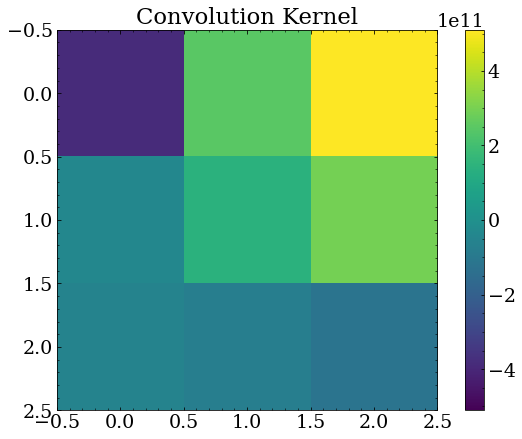

In [13]:
img_conv = conv_neurons[0][0].weights.reshape((3,3))
print(conv_neurons[0][0].threshold)
norm = np.max(np.abs(img_conv))
norm = Normalize(-norm,norm)
plt.title('Convolution Kernel')
plt.imshow(img_conv,norm=norm)
plt.colorbar()

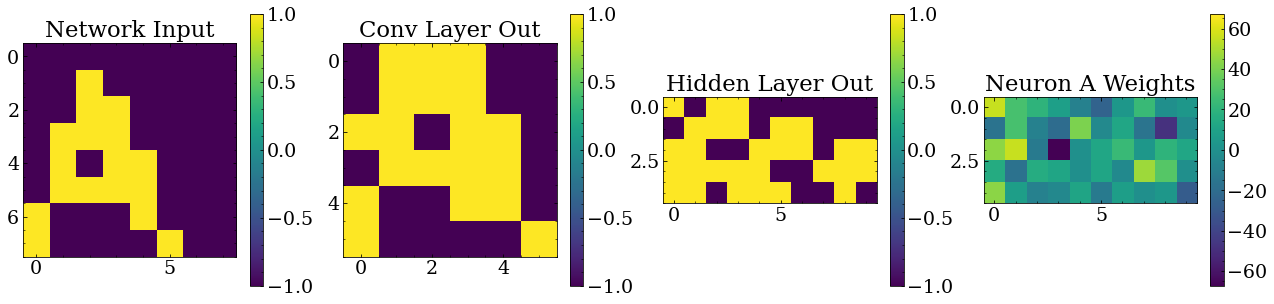

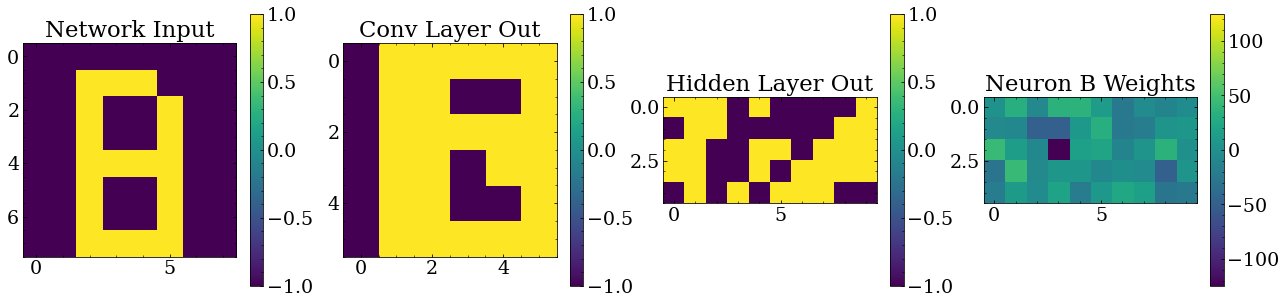

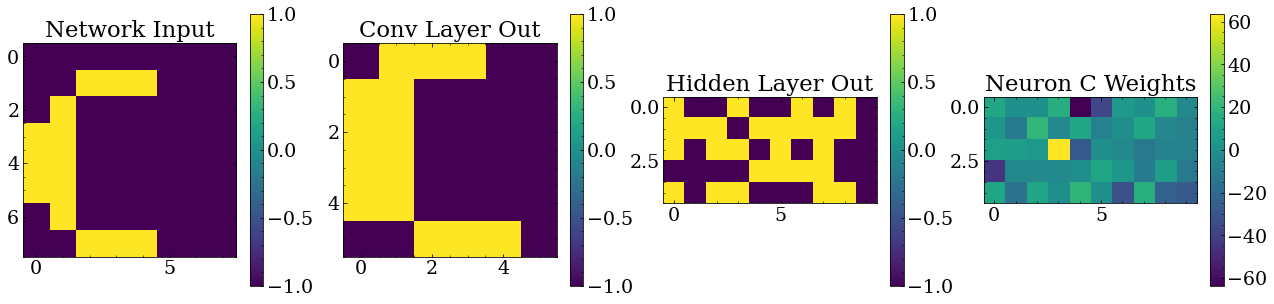

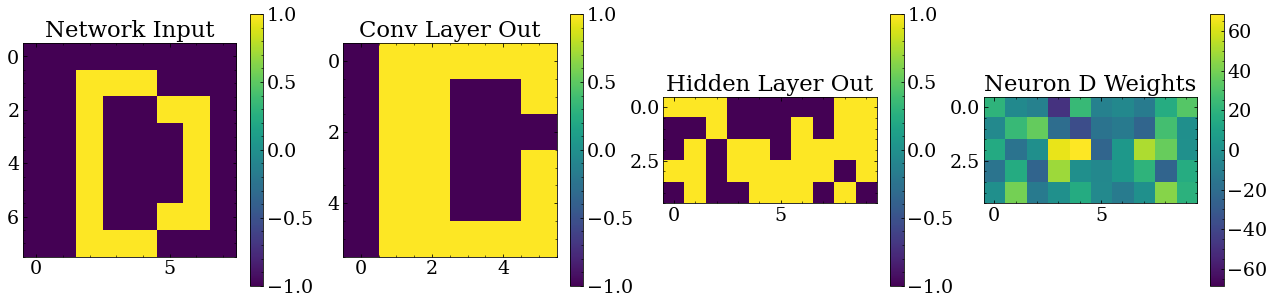

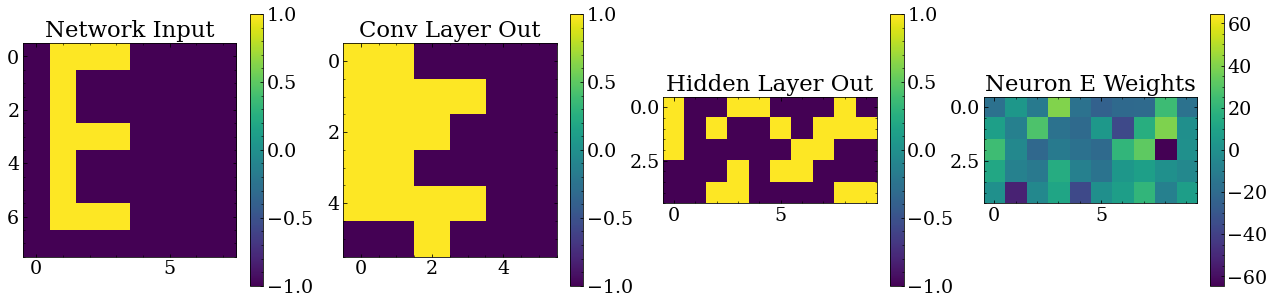

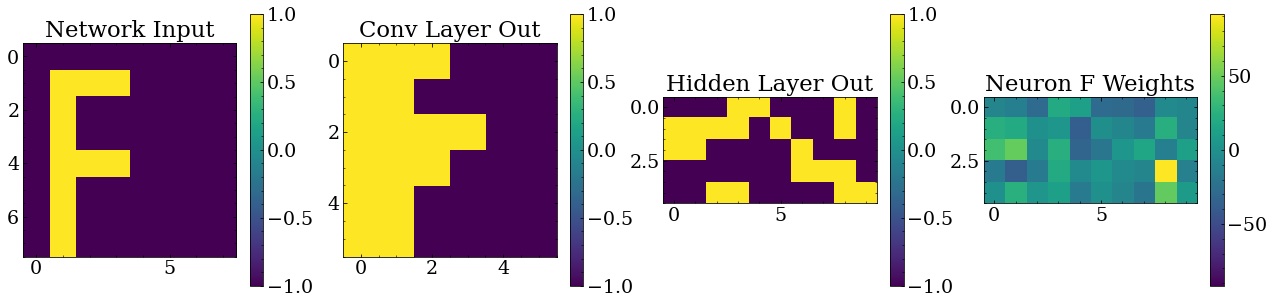

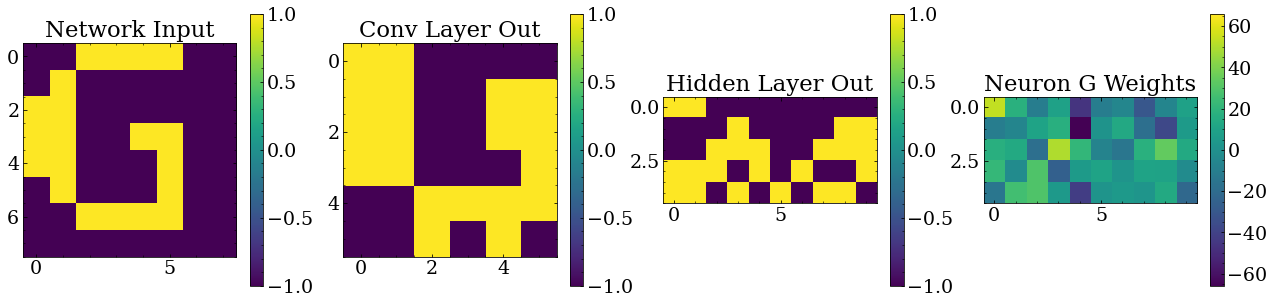

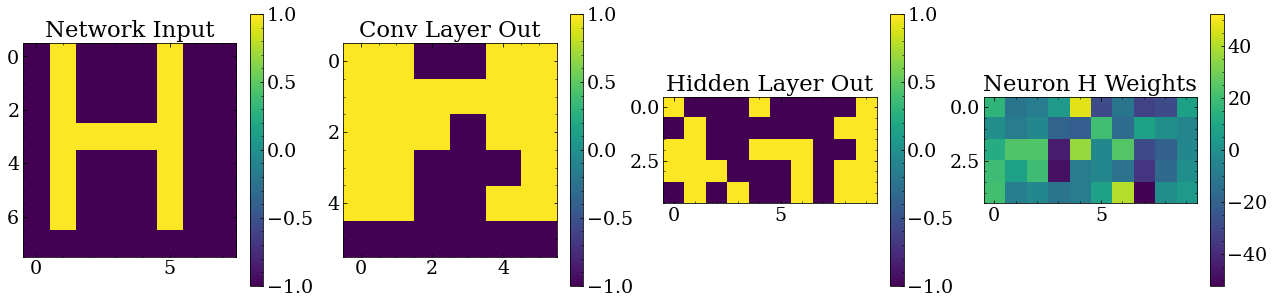

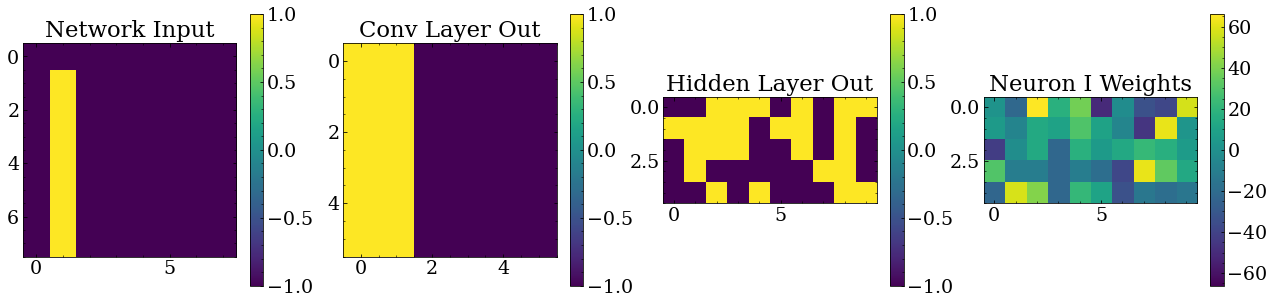

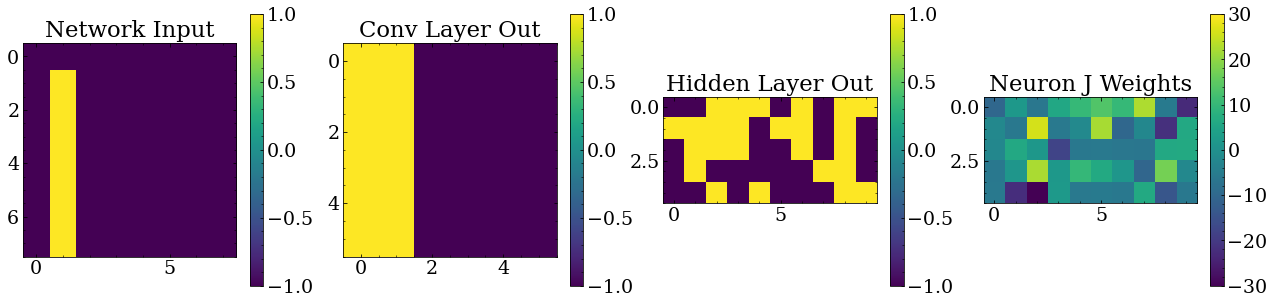

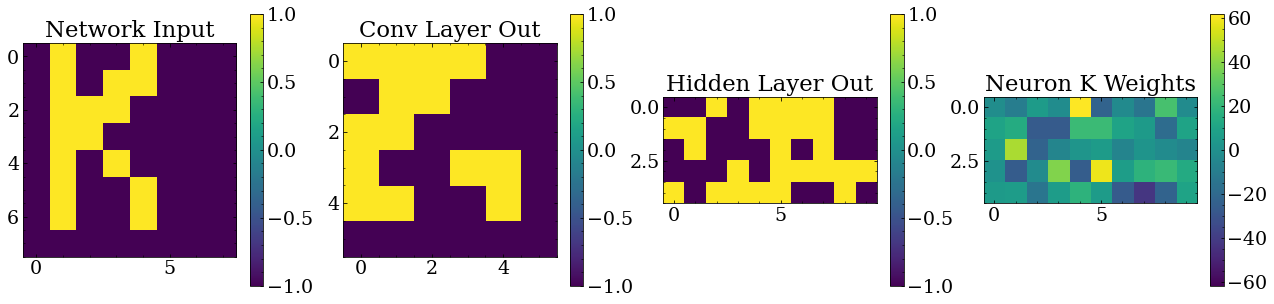

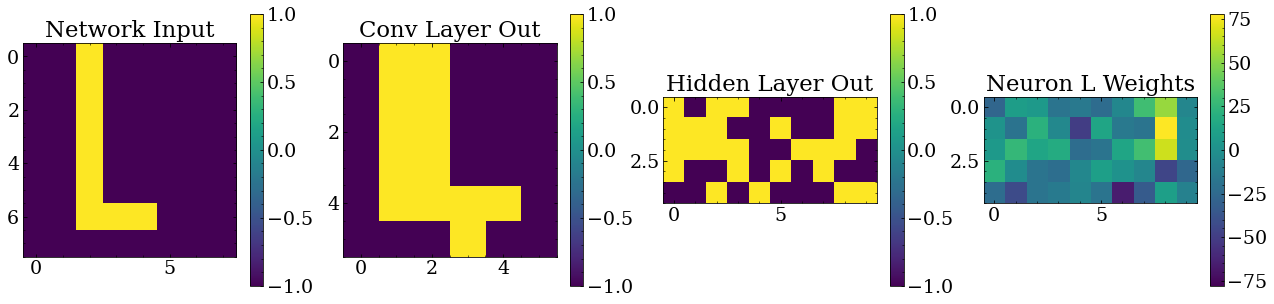

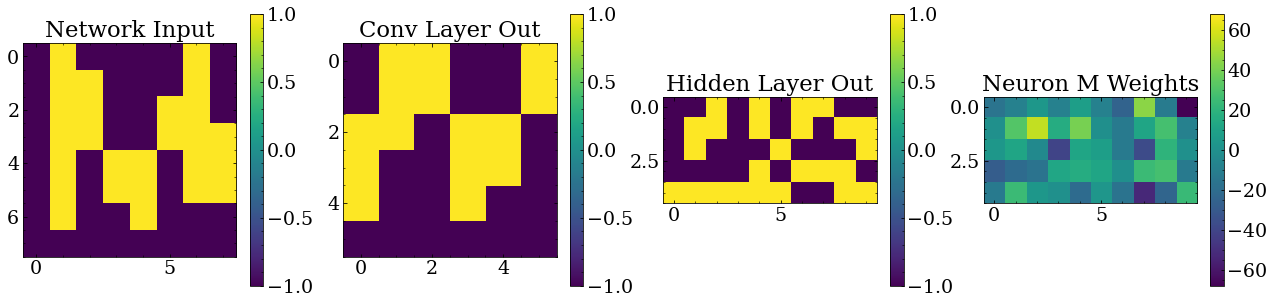

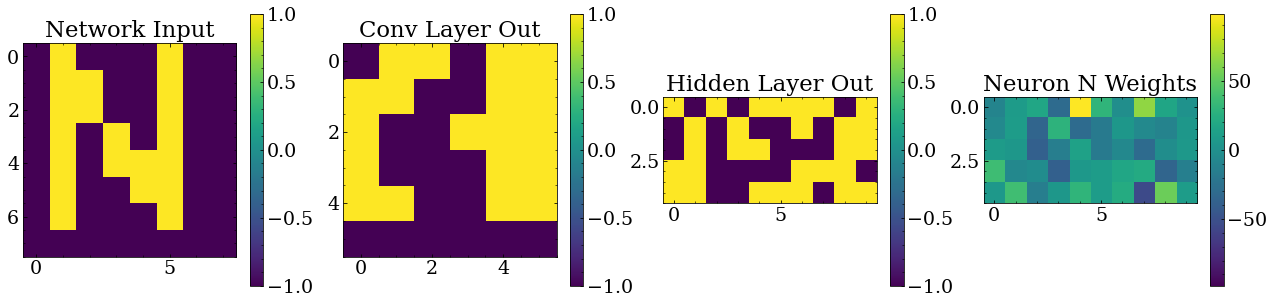

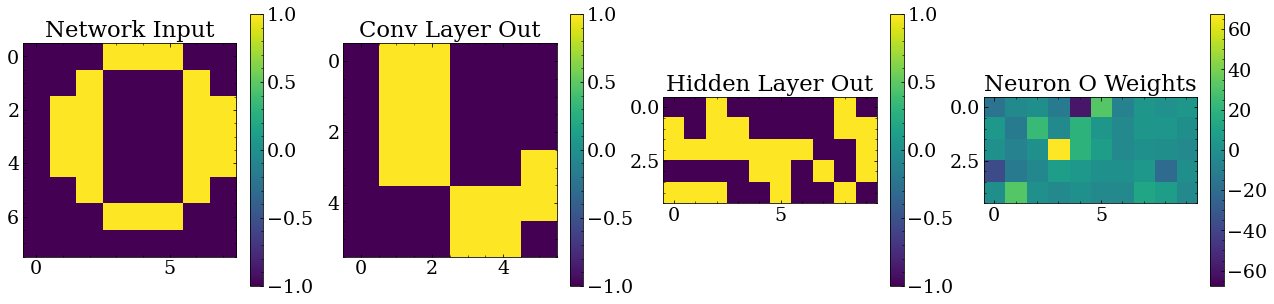

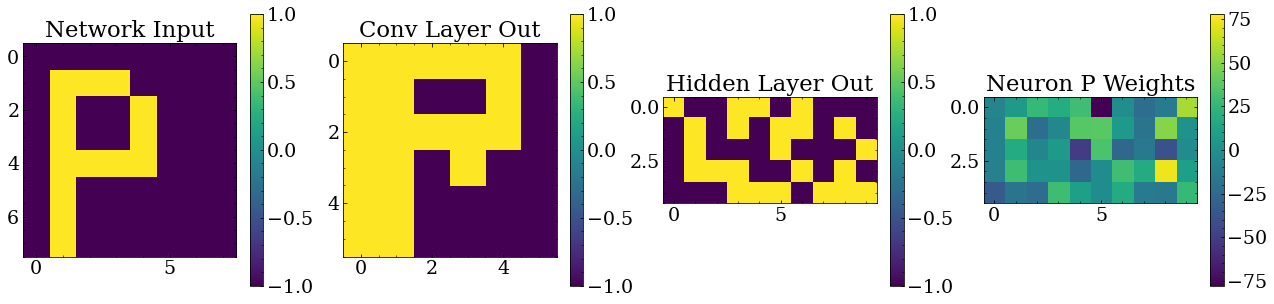

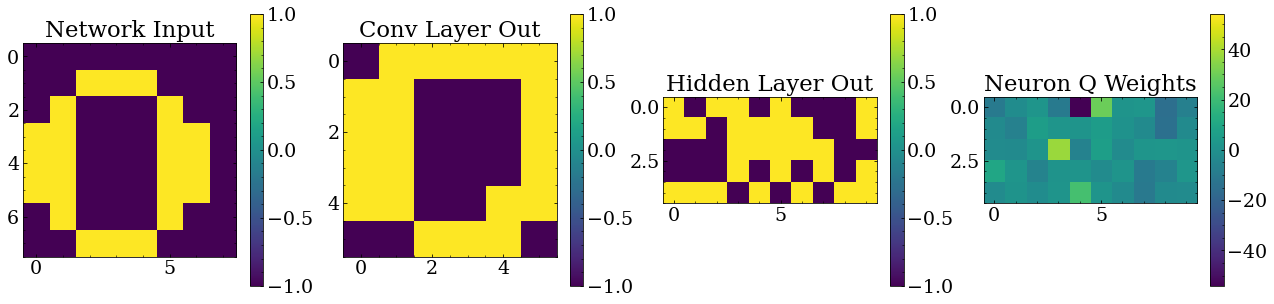

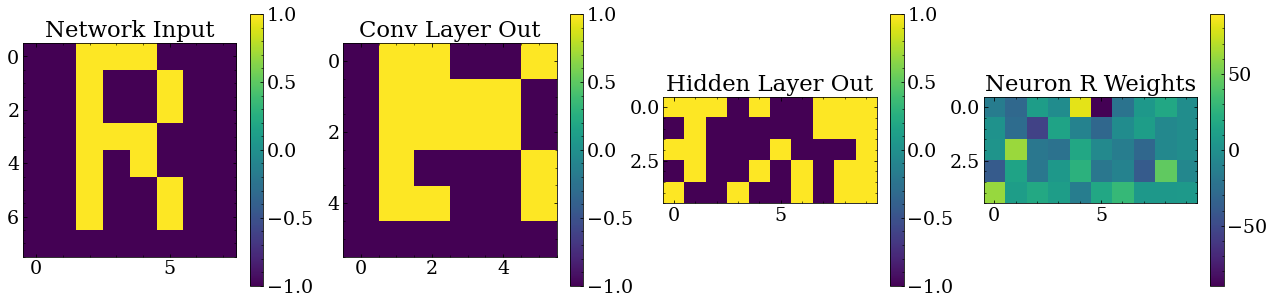

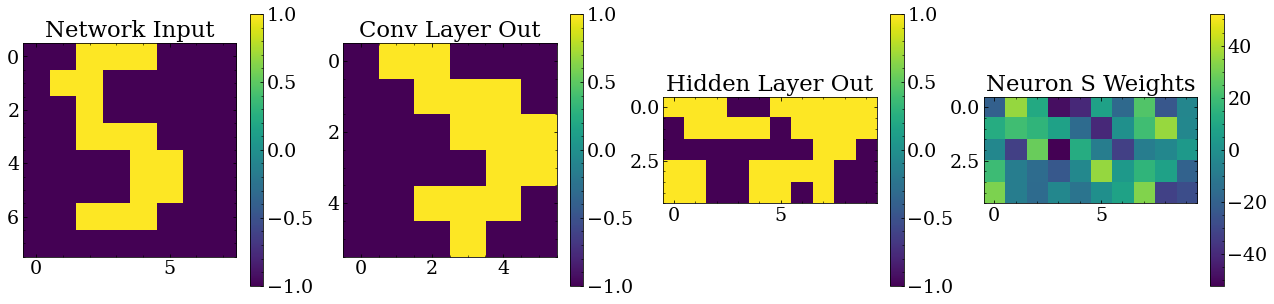

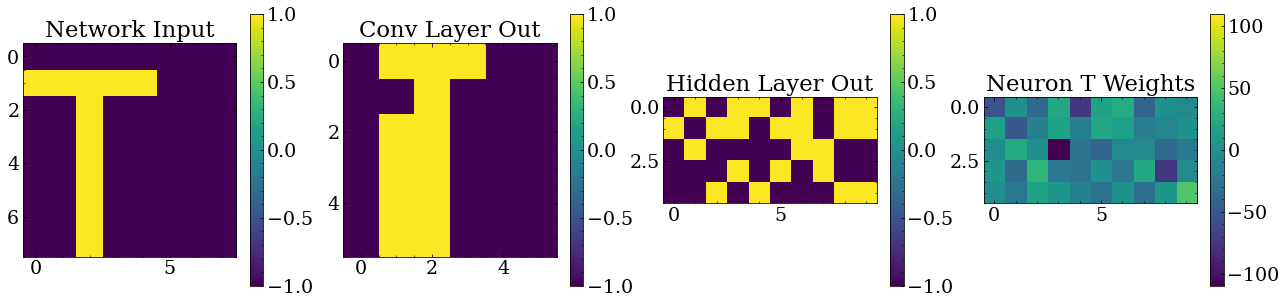

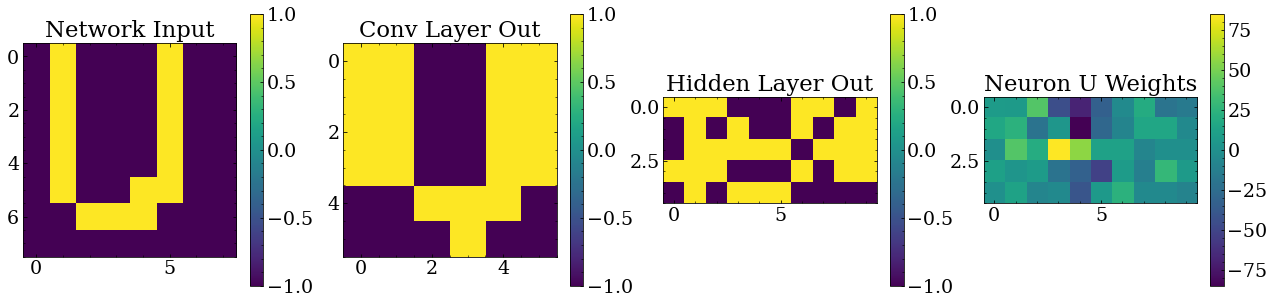

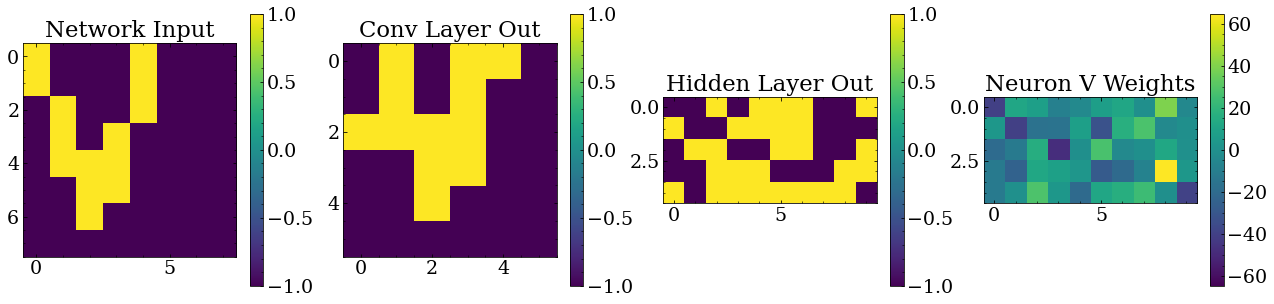

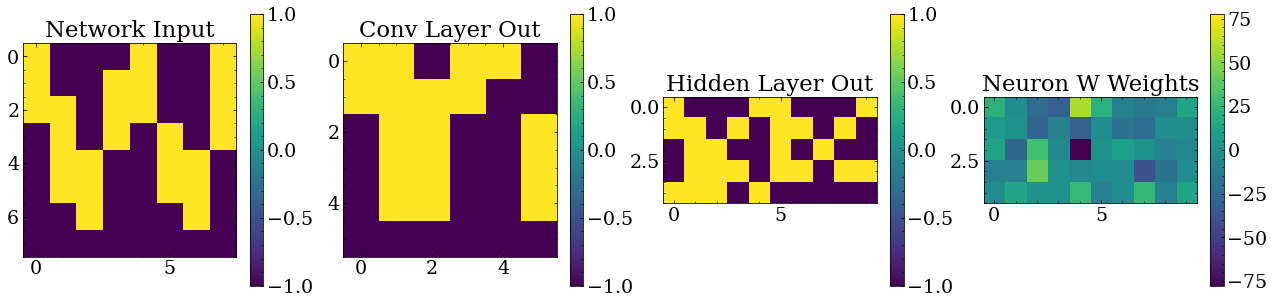

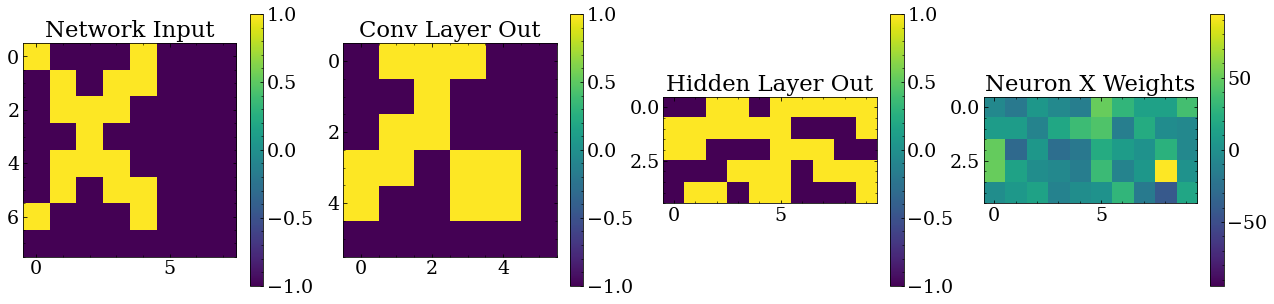

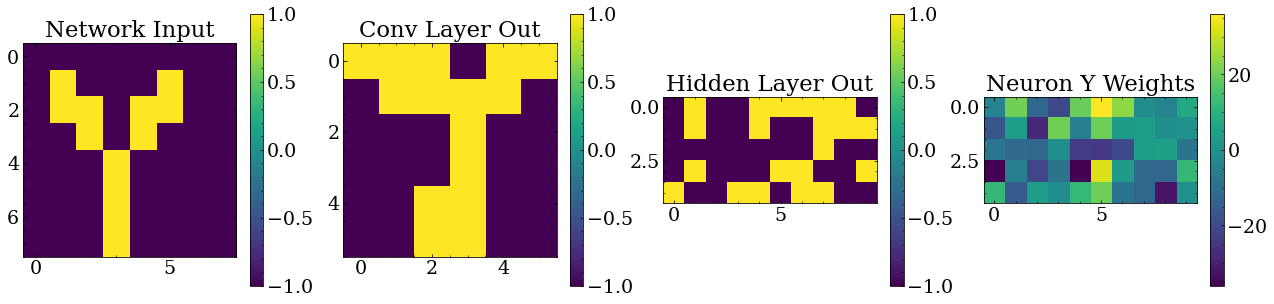

In [14]:
#to plot a simple one hidden layer network

from matplotlib.colors import Normalize

true_norm = Normalize(-1,1)
hidden_shapes = [(5,10)]

for i,iout in enumerate(s.outputs):
    letter = ocr_data.letters[i]
    test_in = ocr_data.gen_data(letter)[1]
    n = s.neurons[iout]
    sort = np.argsort(n.inputs)
    weights = n.weights[sort]
    pltmagic = 100 + 20 + hidden_layers*10 + conv_layers*10
    
    plt.figure(figsize=[22,5])
    plt.subplot(pltmagic+1)
    plt.title('Network Input')
    plt.imshow(test_in,norm=true_norm)
    plt.colorbar()
    
    guess_out,state = s.guess(test_in.flatten(),return_state=True)
    last_shape = test_in.shape
    for i in range(conv_layers):
        width = conv_widths[i]
        last_shape = (last_shape[0]-width+1,last_shape[1]-width+1)
        last_layer = state[[n.index for n in conv_neurons[i]]]
        img_hidden = last_layer.reshape(last_shape)
    
        plt.subplot(pltmagic+2+i)
        plt.title('Conv Layer Out')
        plt.imshow(img_hidden)
        plt.colorbar()
    
    
    for i in range(hidden_layers):
        last_layer = state[[n.index for n in hidden_neurons[i]]]
        img_hidden = last_layer.reshape(hidden_shapes[i])
    
        plt.subplot(pltmagic+2+conv_layers+i)
        plt.title('Hidden Layer Out')
        plt.imshow(img_hidden)
        plt.colorbar()

    plt.subplot(pltmagic+conv_layers+2+hidden_layers)
    plt.title('Neuron ''%s'' Weights'%letter)
    img_weights = weights.reshape(hidden_shapes[-1])
    norm = np.max(np.abs(weights))
    weight_norm = Normalize(-norm,norm)
    plt.imshow(img_weights,norm=weight_norm)
    plt.colorbar()
    plt.show()
    plt.close()

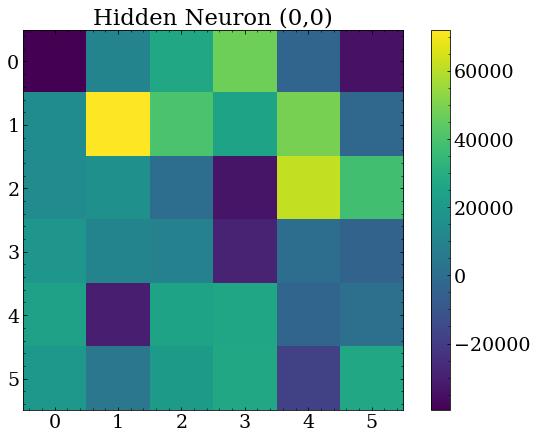

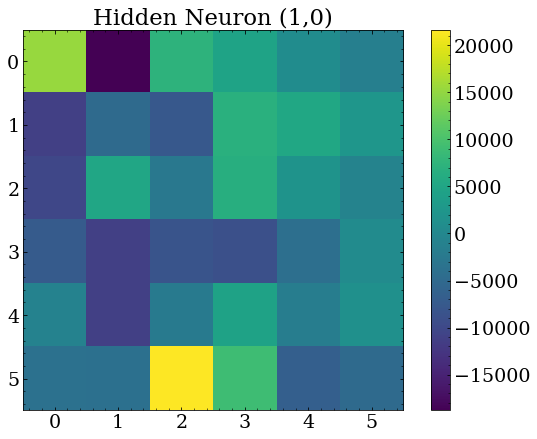

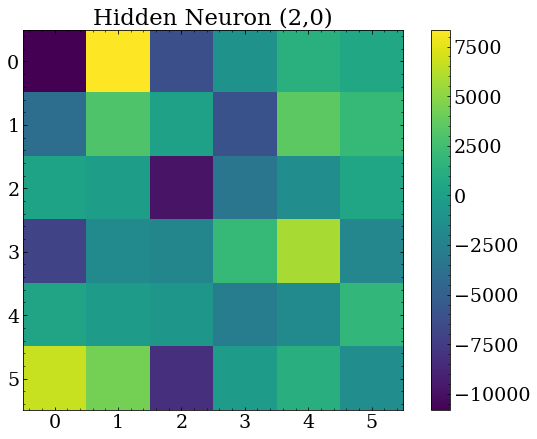

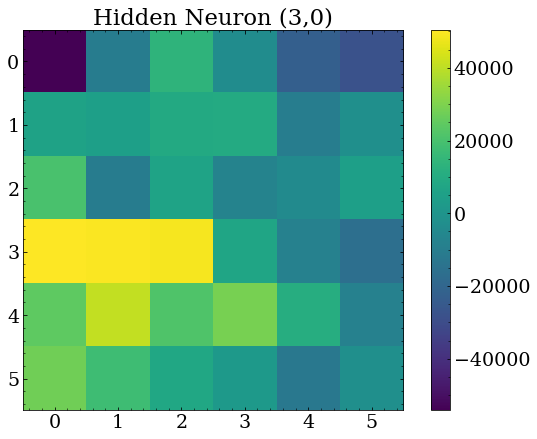

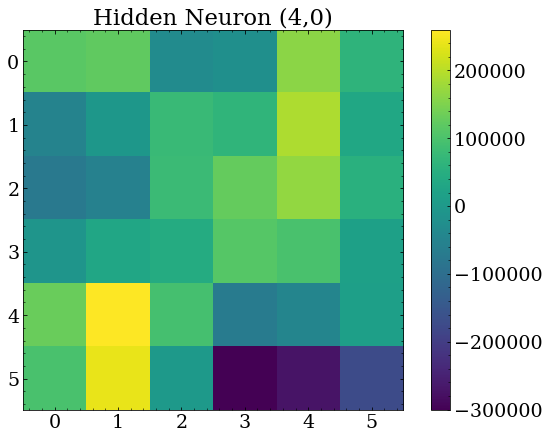

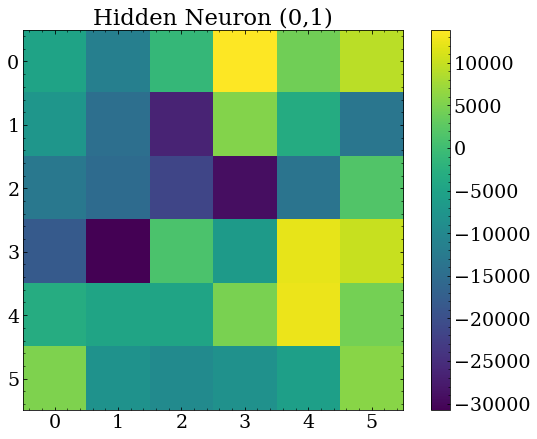

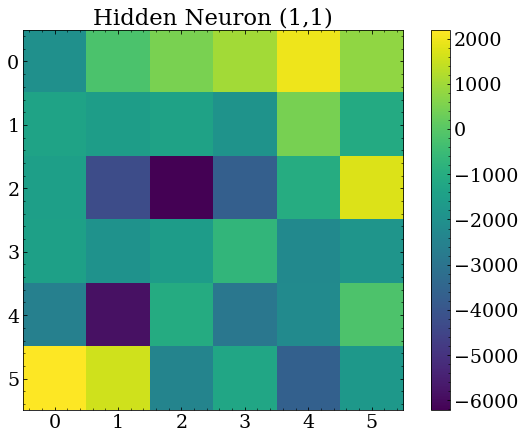

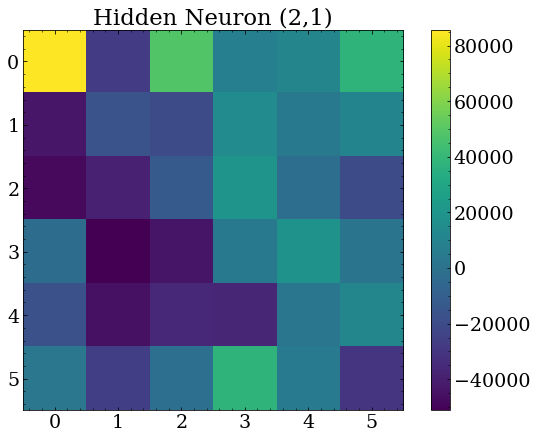

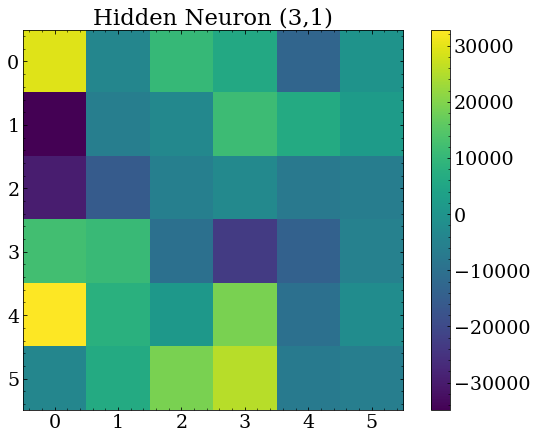

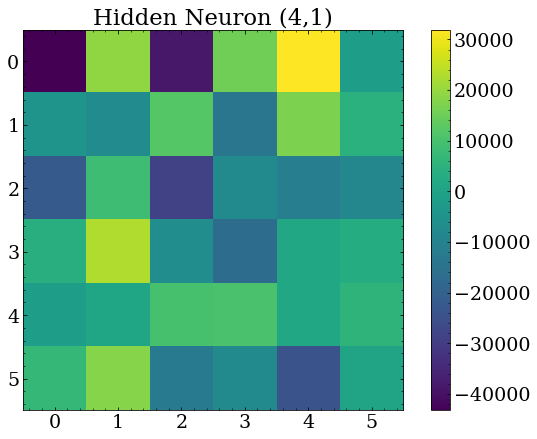

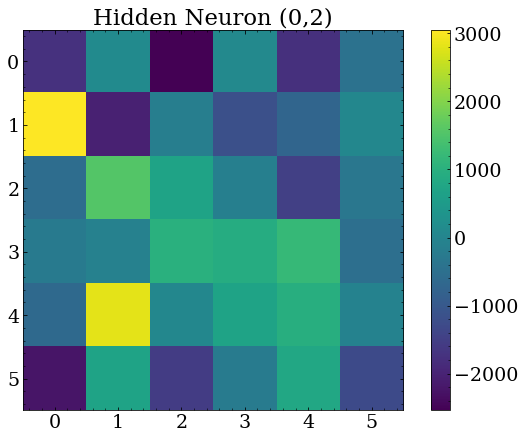

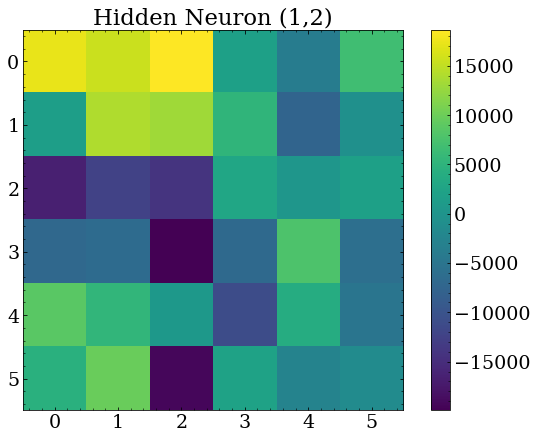

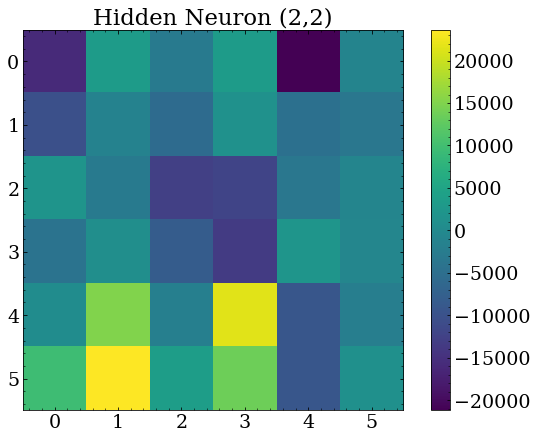

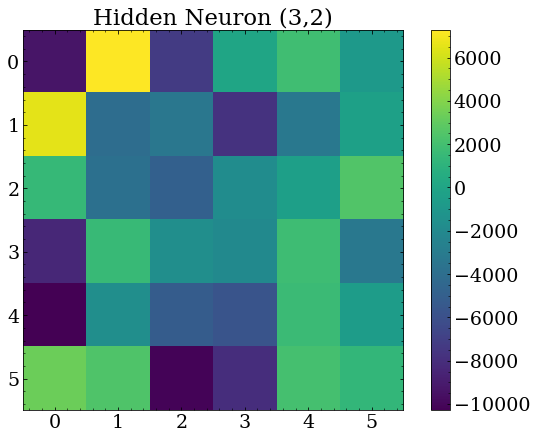

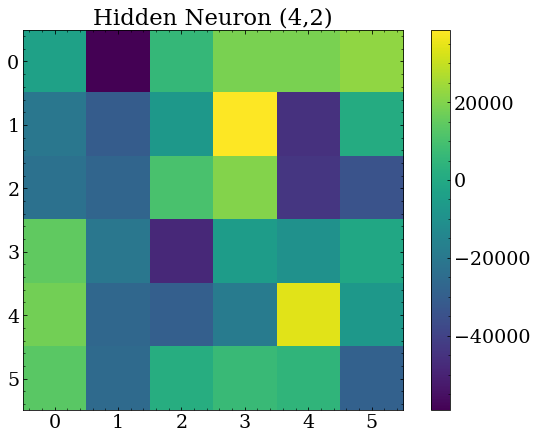

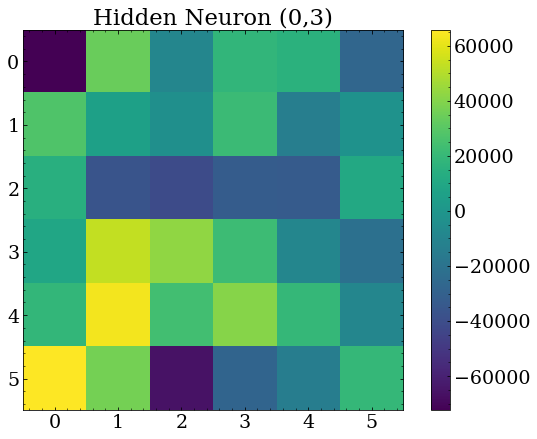

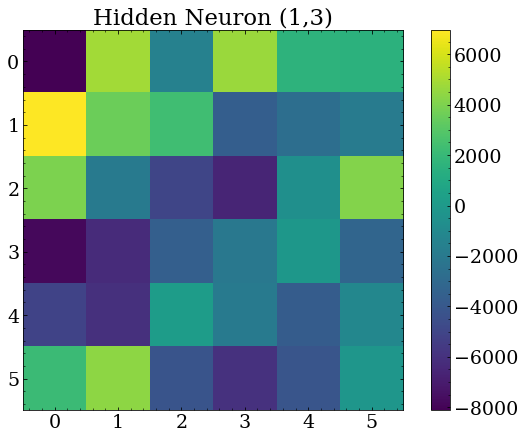

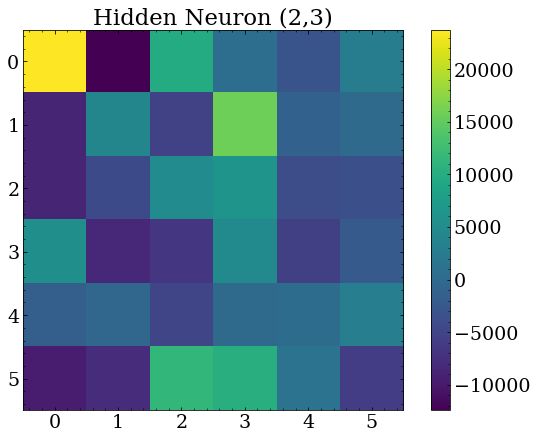

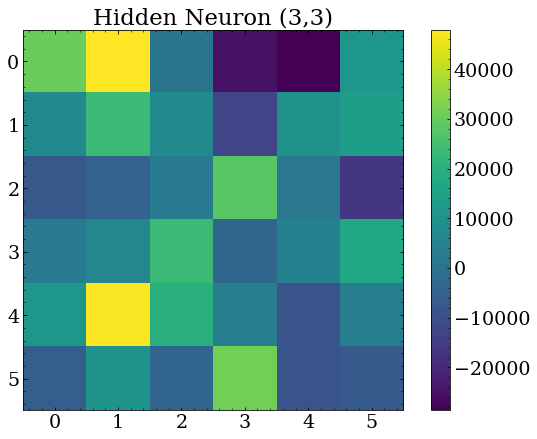

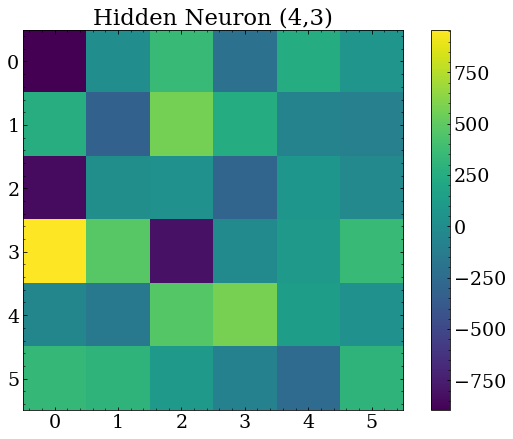

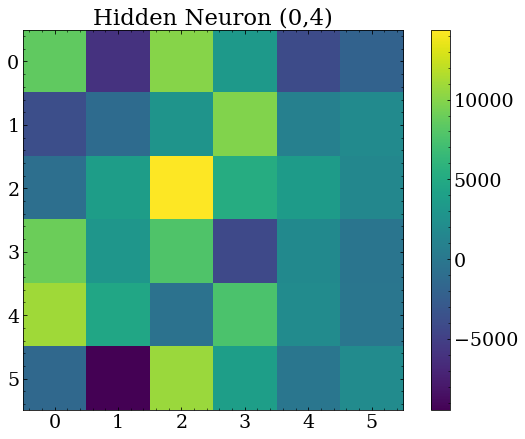

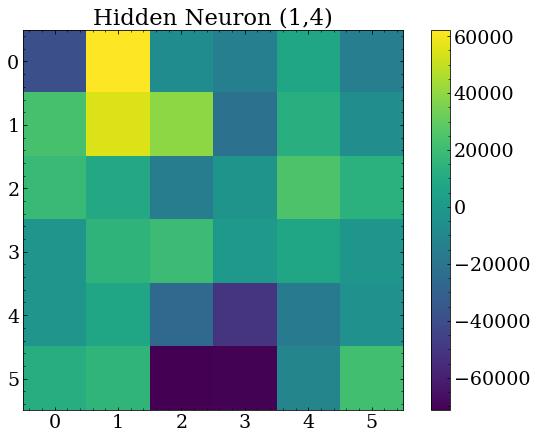

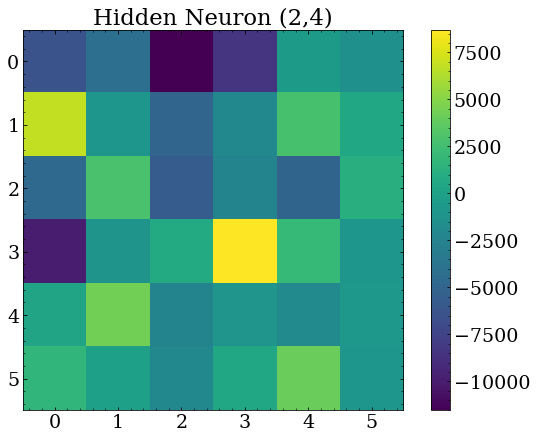

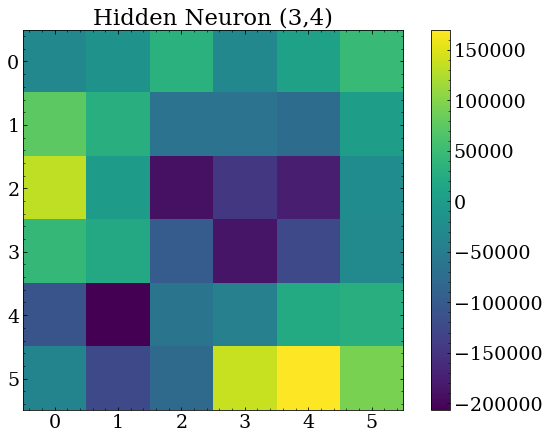

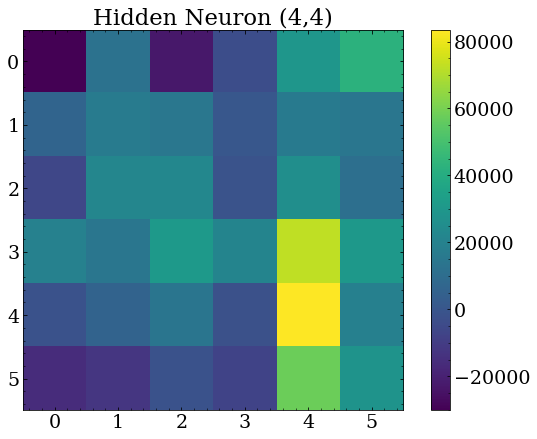

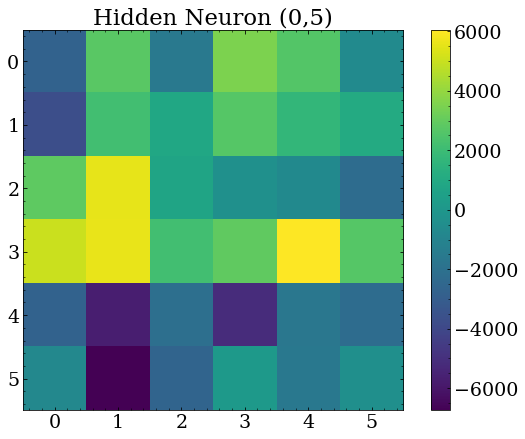

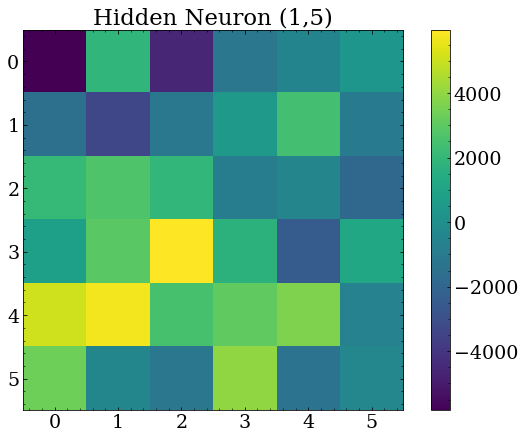

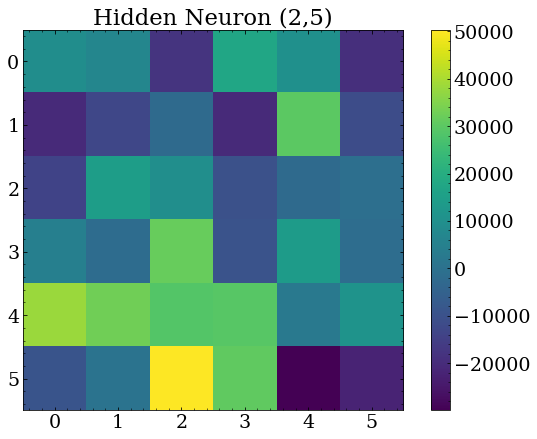

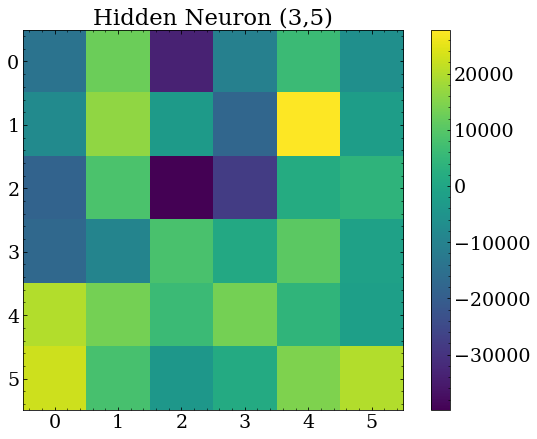

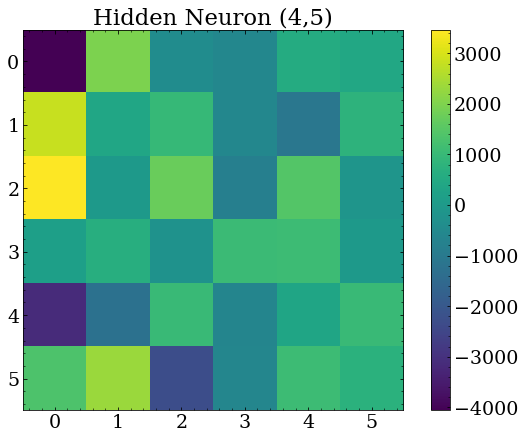

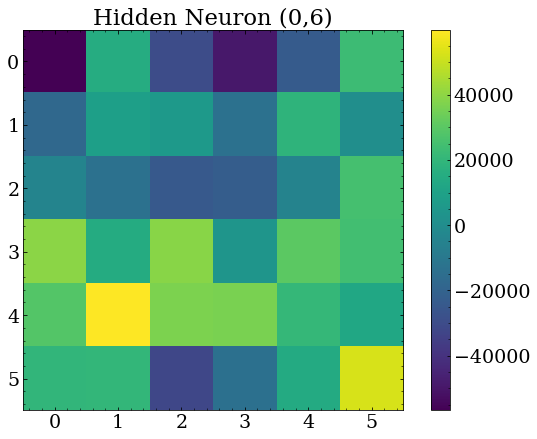

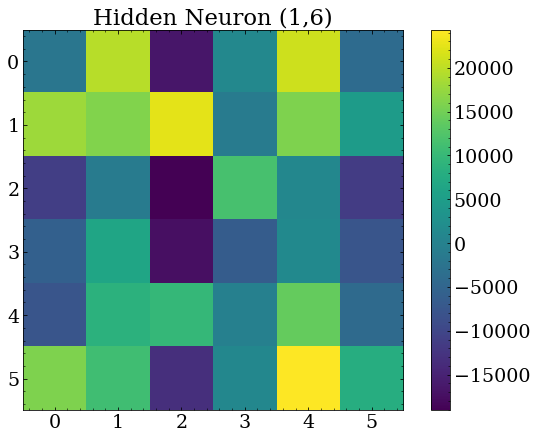

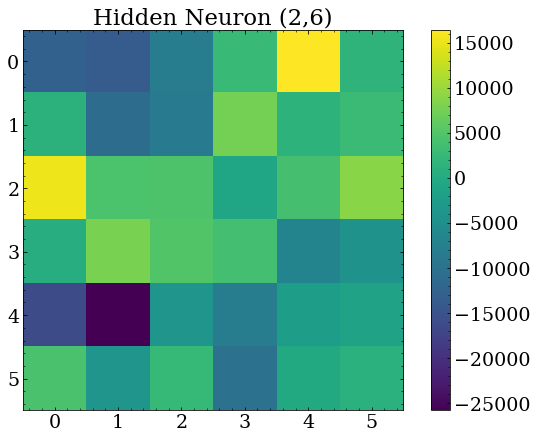

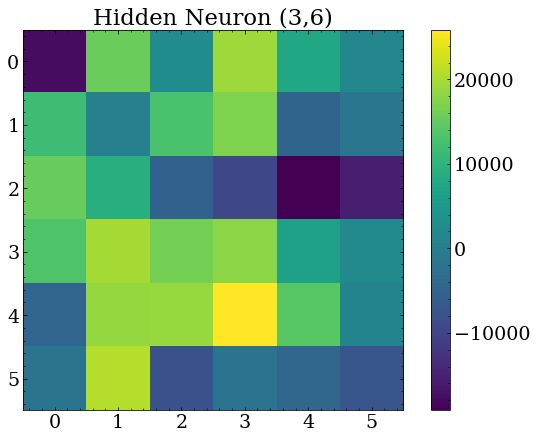

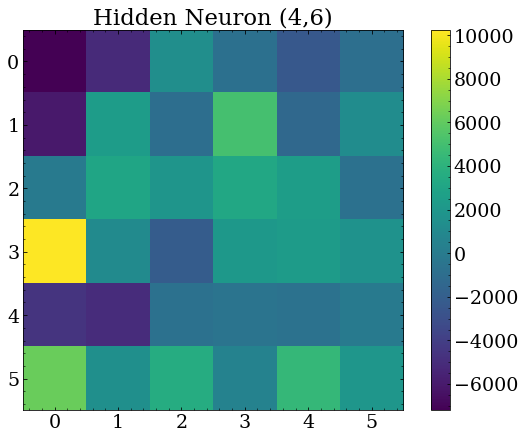

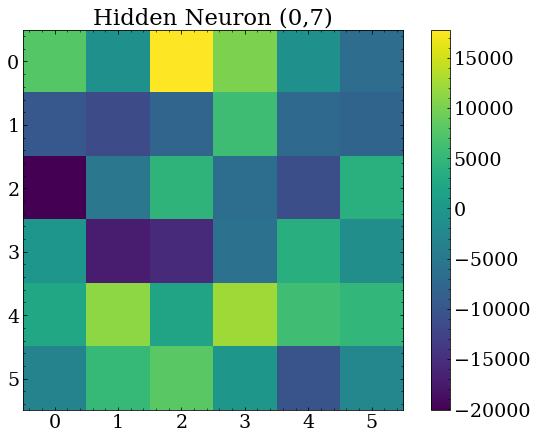

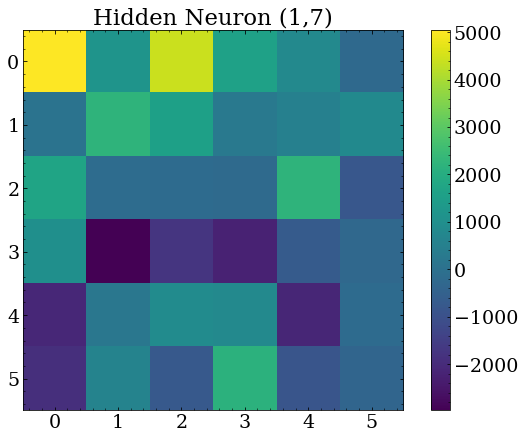

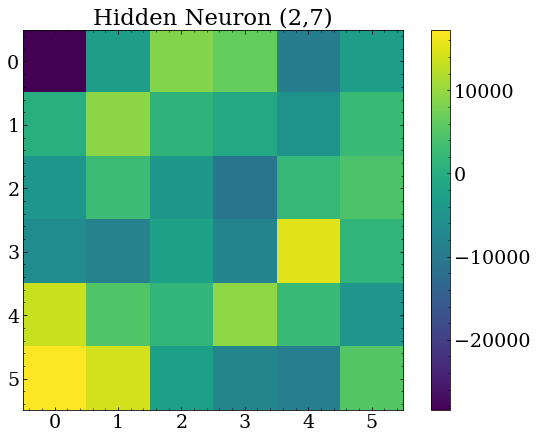

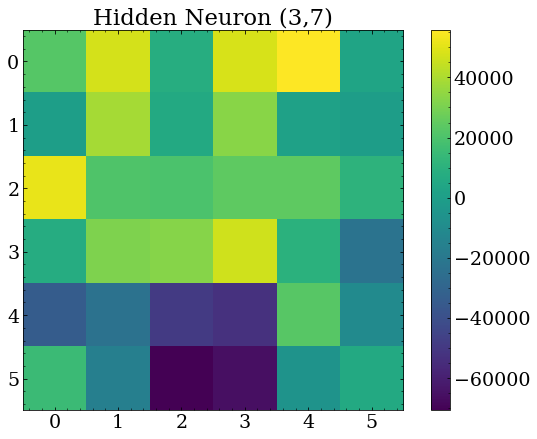

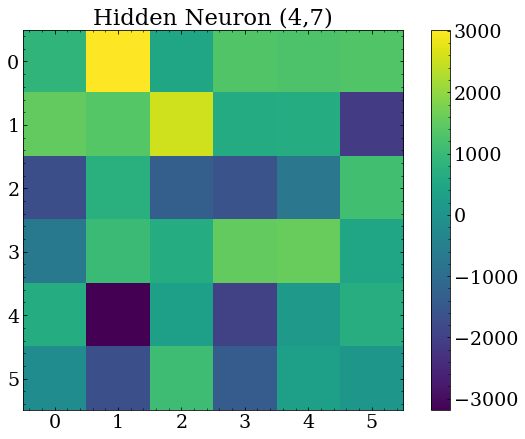

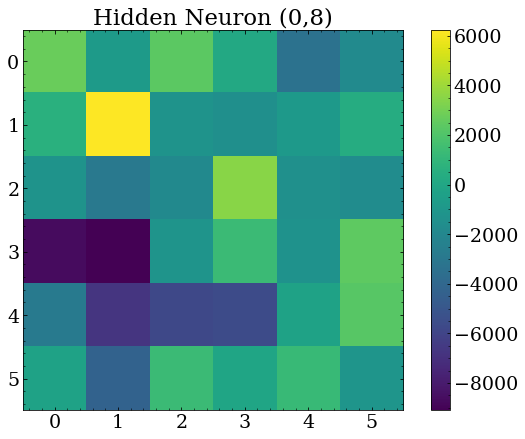

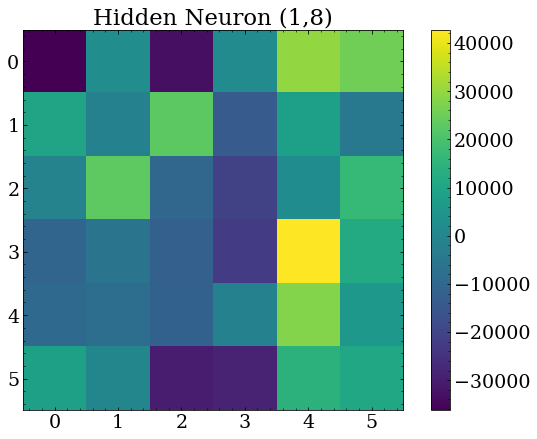

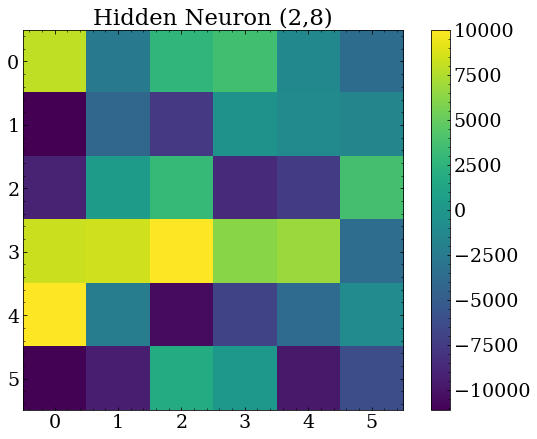

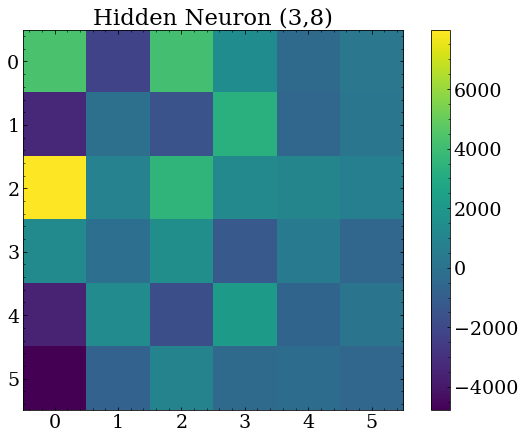

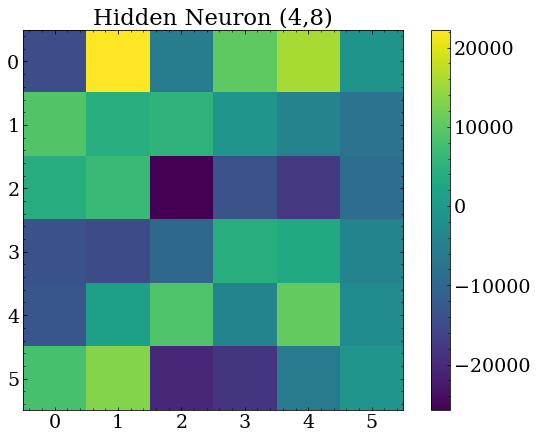

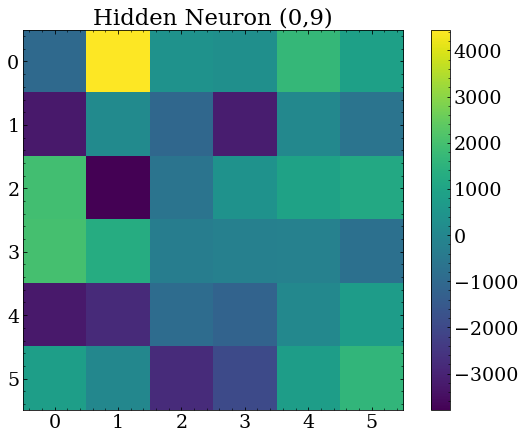

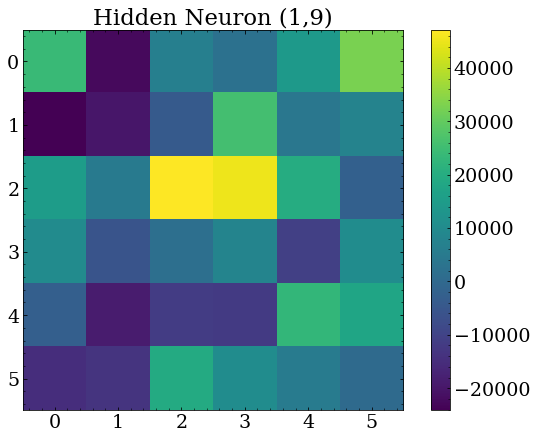

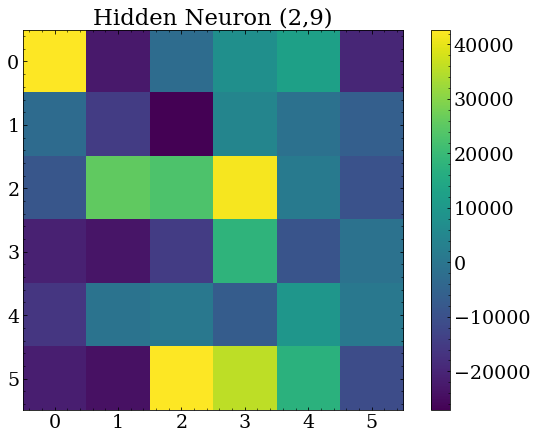

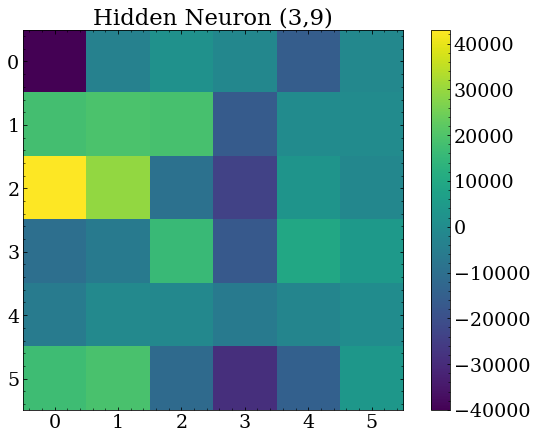

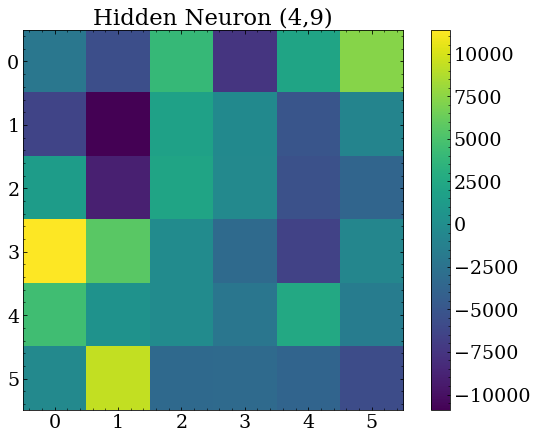

In [16]:
for i in range(hidden_layers):
    for i,n in enumerate(hidden_neurons[i]):
        x = i % hidden_shapes[0][0]
        y = i // hidden_shapes[0][0]
        plt.figure()
        plt.title('Hidden Neuron (%i,%i)'%(x,y))
        plt.imshow(n.weights.reshape((6,6)))
        plt.colorbar()
        plt.show()
        plt.close()